In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.ensemble import RandomForestRegressor


Bad key "text.kerning_factor" on line 4 in
/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [7]:
series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv',index_col=0)
series.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [21]:
series.tail()

,Births
Date,
1959-12-27,37
1959-12-28,52
1959-12-29,48
1959-12-30,55
1959-12-31,50


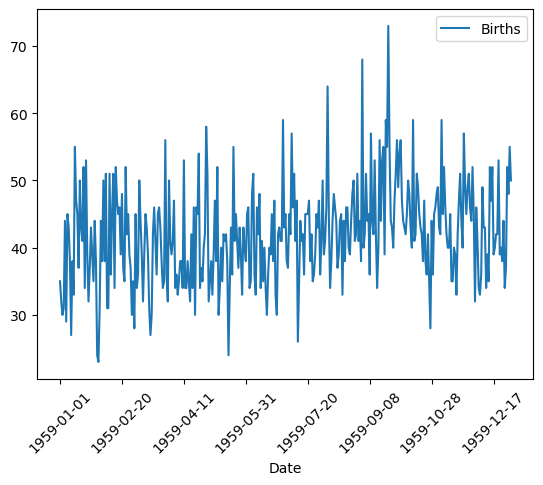

In [8]:
series.plot()
plt.xticks(rotation=45)
plt.show()

In [58]:
# [현 시점의 값, 1 시점 이후의 값] = [input, target] : from time series data to supervised data
def time2supervised(data : np.ndarray, n_in=1, n_out=1):
    if isinstance(data, pd.Series):
        data = data.values
    elif isinstance(data, pd.DataFrame) & (data.shape[1]==1):
        data = data.values.reshape(-1)
    elif isinstance(data, list):
        data = np.array(data)
    length = len(data) - n_in
    supervised_data = data[:length]
    for i in range(1, n_in+n_out):
        supervised_data = np.c_[supervised_data,data[i:length+i]]
    return supervised_data

In [60]:
data = series.copy()
data.shape, time2supervised(data, n_in=2, n_out=1).shape

((365, 1), (363, 3))

In [25]:
# 시계열에서의 train test set 분리는 순서에 맞게 해야 함
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [99]:
# random forest forecast
def random_forest_forecast(train, testX, random_state=42):
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit
    model = RandomForestRegressor(n_estimators=1000, random_state=random_state)
    model.fit(trainX, trainy)
    # predict
    return model.predict(testX)

In [100]:
supervised_input = time2supervised(data, n_in=6, n_out=1)
test_size = 30
train, test = train_test_split(supervised_input, test_size)

In [101]:
forcasted = random_forest_forecast(train, test[:, :-1])

In [102]:
print(f'실제값 : {list(test[:,-1])}')
print(f'예측값 : {list(forcasted)}')

실제값 : [32, 46, 41, 34, 33, 36, 49, 43, 43, 34, 39, 35, 52, 47, 52, 39, 40, 42, 42, 53, 39, 40, 38, 44, 34, 37, 52, 48, 55, 50]
예측값 : [44.77, 43.162, 44.799, 44.401, 40.518, 42.14, 36.513, 41.2, 43.264, 39.029, 40.299, 42.273, 40.771, 41.016, 43.097, 39.697, 40.516, 45.22, 45.625, 43.909, 41.255, 38.286, 42.402, 48.21, 41.351, 36.972, 38.658, 41.571, 43.59, 45.554]


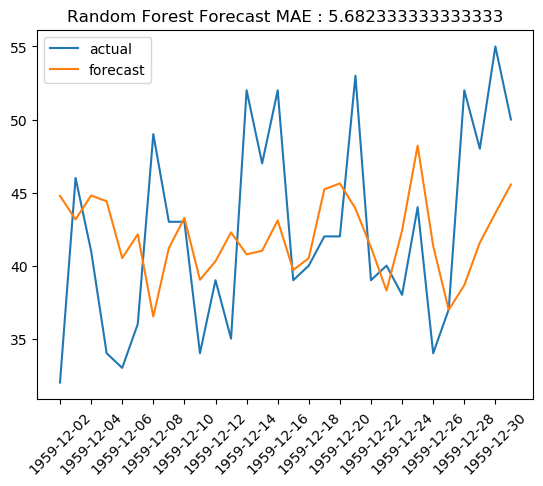

In [103]:
plt.plot(test[:,-1], label='actual')
plt.plot(forcasted, label='forecast')
plt.legend()
plt.xticks(list(range(test_size))[::2], labels=data.index[-test_size:].tolist()[::2],rotation=45)
plt.title(f'Random Forest Forecast MAE : {MAE(test[:,-1], forcasted)}')
plt.show()

In [104]:
def random_forest_forecast_tr_val(train, testX, random_state=42):
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit
    model = RandomForestRegressor(n_estimators=1000, random_state=random_state)
    model.fit(trainX, trainy)
    # predict
    train_pred = model.predict(trainX)
    test_pred = model.predict(testX)
    return train_pred, test_pred

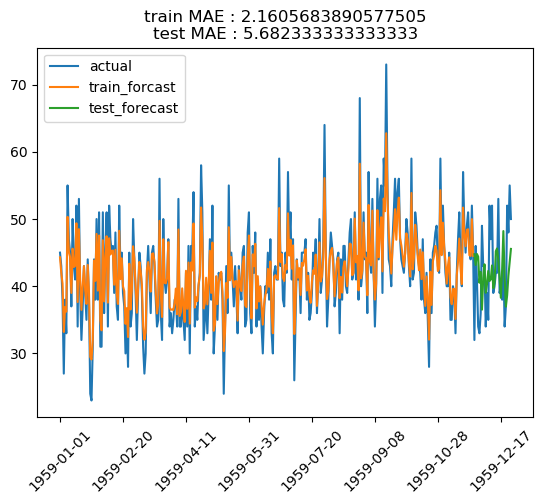

In [105]:
train_pred, test_pred = random_forest_forecast_tr_val(train, test[:, :-1])

plt.plot(np.r_[train[:,-1],test[:,-1]], label='actual')
plt.plot(range(len(train_pred)),train_pred, label='train_forcast')
plt.plot(range(len(train_pred), len(train_pred)+len(test_pred)),test_pred, label='test_forecast')
plt.legend()
plt.xticks(list(range(data.shape[0]))[::50], labels=data.index.tolist()[::50],rotation=45)
plt.title(f'train MAE : {MAE(train[:,-1], train_pred)}\ntest MAE : {MAE(test[:,-1], test_pred)}')
plt.show()
